In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
y = train_df['label'].values
X = train_df.drop('label', axis=1).values

## Prepare dataset

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32) / 255.0
X_val = torch.tensor(X_val, dtype=torch.float32) / 255.0
X_test = torch.tensor(test_df.values, dtype=torch.float32) / 255.0

In [6]:
X_train = X_train.view(-1, 1, 28, 28)
X_val = X_val.view(-1, 1, 28, 28)
X_test = X_test.view(-1, 1, 28, 28)

In [7]:
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

In [8]:
# Needed for PyTorch, would've been easier to use PyTorch's own MNIST dataset in other circumstances
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

In [10]:
train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Model

### Prepare model

In [78]:
resnet = models.resnet18(pretrained=True)

In [79]:
# Modify the first convolutional layer to accept 1-channel input instead of 3 channels
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

In [80]:
# Modify the final fully connected layer to output 10 classes instead of 1000
resnet.fc = nn.Linear(resnet.fc.in_features, 10)

### Training loop

In [81]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet.to(device)

In [82]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.00025, weight_decay=1e-4)

In [83]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [84]:
num_epochs = 30

In [85]:
best_val_acc = 0.0
best_model_path = 'best_model.pth'

In [86]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    resnet.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train

    # Validation phase
    resnet.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_acc = correct_val / total_val
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}")

    train_losses.append(loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet.state_dict(), best_model_path)  # Save the best model
        print(f"New best resnet saved at epoch {epoch+1} with validation accuracy: {val_acc:.4f}")
    
    scheduler.step(val_loss)

Epoch 1/25, Train Loss: 0.2766, Train Acc: 0.9159, Val Loss: 0.0871, Val Acc: 0.9725
New best resnet saved at epoch 1 with validation accuracy: 0.9725
Epoch 2/25, Train Loss: 0.0896, Train Acc: 0.9743, Val Loss: 0.0632, Val Acc: 0.9796
New best resnet saved at epoch 2 with validation accuracy: 0.9796
Epoch 3/25, Train Loss: 0.0612, Train Acc: 0.9818, Val Loss: 0.0508, Val Acc: 0.9858
New best resnet saved at epoch 3 with validation accuracy: 0.9858
Epoch 4/25, Train Loss: 0.0465, Train Acc: 0.9863, Val Loss: 0.0608, Val Acc: 0.9820
Epoch 5/25, Train Loss: 0.0424, Train Acc: 0.9872, Val Loss: 0.0576, Val Acc: 0.9825
Epoch 6/25, Train Loss: 0.0370, Train Acc: 0.9888, Val Loss: 0.0449, Val Acc: 0.9877
New best resnet saved at epoch 6 with validation accuracy: 0.9877
Epoch 7/25, Train Loss: 0.0327, Train Acc: 0.9896, Val Loss: 0.0472, Val Acc: 0.9854
Epoch 8/25, Train Loss: 0.0268, Train Acc: 0.9917, Val Loss: 0.0627, Val Acc: 0.9819
Epoch 9/25, Train Loss: 0.0285, Train Acc: 0.9912, Val L

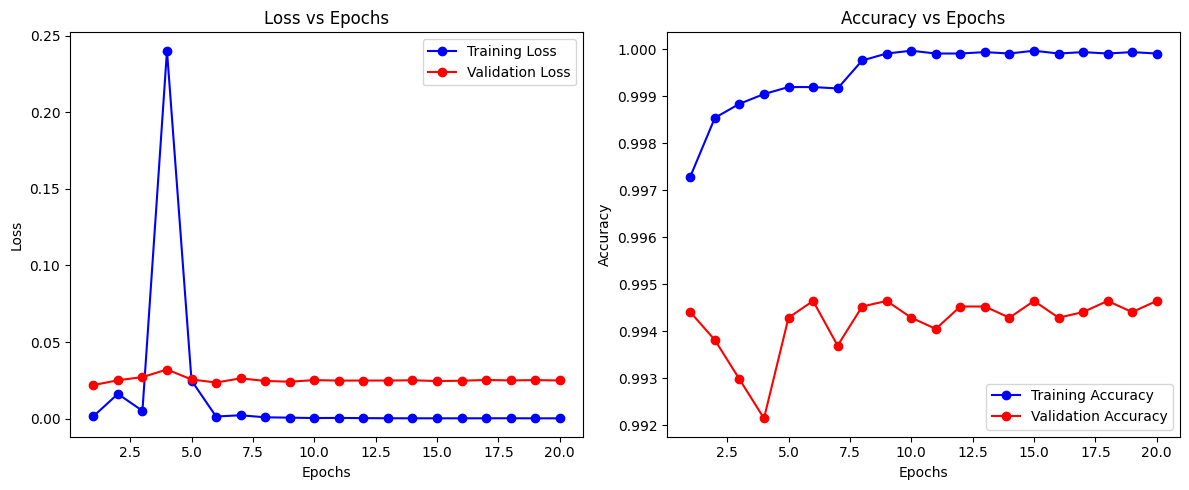

In [36]:
epochs = range(1, num_epochs + 1)

train_losses_cpu = [loss.cpu().numpy() for loss in train_losses]

plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_cpu, 'bo-', label='Training Loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluate

In [38]:
best_model = models.resnet18(pretrained=False)
best_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
best_model.fc = nn.Linear(best_model.fc.in_features, 10)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
best_model.load_state_dict(torch.load(best_model_path))

/tmp/ipykernel_36/2033124005.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [40]:
best_model = best_model.to(device)
best_model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
val_loss = 0.0
correct = 0
total = 0

In [42]:
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = 100 * correct / total
print(f'Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_accuracy:.2f}%')

Validation Loss: 0.02492744280779434, Validation Accuracy: 99.46%


## Get submission

In [45]:
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [46]:
best_model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

all_predictions = []

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)
        outputs = best_model(inputs)
        _, predictions = torch.max(outputs, 1)
        all_predictions.append(predictions.cpu().numpy())

In [49]:
all_predictions = np.concatenate(all_predictions)

predictions_list = all_predictions.tolist()

In [50]:
submission = pd.DataFrame(predictions_list)
submission.index.name='ImageId'
submission.index+=1
submission.columns=['Label']

In [52]:
submission.to_csv('submission.csv', index="ImageId")